In [22]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from torch.distributions import Normal

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#####################  hyper parameters  ####################

MAX_EPISODES = 2001              
MAX_EP_STEPS = 75               

RENDER = False

LOAD_MEM = False
LOAD_MODEL = True
LOAD_FOLDER_NAME = 'random5_60step_pre/1950epi'

LOAD_PRETRAIN = False

CHECK_POINT_EPI = 50


ENV_NAME = 'OpenCabinetDrawer-v0'       
SEED = 123                      

var = 5
var_low_bound = 0.05

In [23]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,hidden_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.hidden_dim = hidden_dim
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                      # learning rate for actor
        self.lr_c = 0.001                                                                       # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        self.Success_record = np.zeros(MAX_EPISODES)
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound,hidden_size):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                
                self.linear1 = nn.Linear(s_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear4 = nn.Linear(hidden_size, a_dim)
                
                
                self.linear4.weight.data.uniform_(-0.03, 0.03)
                self.linear4.bias.data.uniform_(-0.03, 0.03)
#                 self.fc1 = nn.Linear(s_dim,256)
#                 self.fc1.weight.data.normal_(0,0.1)          # initialization
                
#                 self.fc2 = nn.Linear(256,512)
#                 self.fc2.weight.data.normal_(0,0.1)
#                                
#                 self.fc3 = nn.Linear(512,256)
#                 self.fc3.weight.data.normal_(0,0.1)
                
#                 self.out = nn.Linear(256,a_dim)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))
                x = F.tanh(self.linear4(x))
                
#                 x = self.fc1(x)
#                 x = F.relu(x)
#                  
#                 x = self.fc2(x)
#                 x = F.relu(x)
                
#                 x = self.fc3(x)
#                 x = F.relu(x)
                
#                 x = self.out(x)
#                 x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim,hidden_size):
                super(CNet,self).__init__()
                
                self.linear1 = nn.Linear(s_dim + a_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
#                 self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, 1)
                

                self.linear3.weight.data.uniform_(-0.03,0.03)
                self.linear3.bias.data.uniform_(-0.03,0.03)

#                 self.fcs1 = nn.Linear(s_dim,256)
#                 self.fcs1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs2 = nn.Linear(256,512)
#                 self.fcs2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs3 = nn.Linear(512,256)
#                 self.fcs3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01) 
                
#                 self.fca1 = nn.Linear(a_dim,256)
#                 self.fca1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fca2 = nn.Linear(256,512)
#                 self.fca2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)              
                
#                 self.fca3 = nn.Linear(512,256)
#                 self.fca3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.out = nn.Linear(256,1)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
        
                x = torch.cat([s, a], 1)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
#                 x = F.relu(self.linear3(x))
                x = self.linear3(x)

#                 x = self.fcs1(s)                              # 输入状态
#                 x = F.relu(x)
                
#                 x = self.fcs2(x)
#                 x = F.relu(x)
                
#                 x = self.fcs3(x)
#                 x = F.relu(x) 
                
#                 y = self.fca1(a)                              # 输入动作
#                 y = F.relu(y)
                
#                 y = self.fca2(y)                              
#                 y = F.relu(y)
                
#                 y = self.fca3(y)                              
#                 y = F.relu(y)
                
#                 net = F.relu(x+y)
#                 actions_value = self.out(net)                # 给出V(s,a)
                return x

        self.Actor_eval = ANet(s_dim, a_dim, a_bound, hidden_dim)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound, hidden_dim)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim,hidden_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim,hidden_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)

        return self.Actor_eval(s)[0].detach()                

    def learn(self):

        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  

        loss_a = -torch.mean(q)            
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      
        q_ = self.Critic_target(bs_,a_)  
        q_target = br + self.gamma * q_  

        q_v = self.Critic_eval(bs,ba)

        td_error = self.loss_td(q_target,q_v)

        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                              
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def Record_success(self,epi):
        self.Success_record[epi] = 1
        
    def save(self,folder_name):
    
        if os.path.exists('./DPG model/' + folder_name):
            os.remove('./DPG model/' + folder_name)
            
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Success_record.csv'
        xml_df = pd.DataFrame(self.Success_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
#         ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_eval.eval()
#         ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_target.eval() 


Load network parameters of: random5_60step_pre/1950epi
Episode: 0  Reward: 446 Explore: 0.10
Episode: 1  Reward: -86 Explore: 0.10
Episode: 2  Reward: -71 Explore: 0.10
SUCCESS
Episode: 3  Reward: 801 Explore: 0.10
SUCCESS
Episode: 4  Reward: 990 Explore: 0.10
Episode: 5  Reward: -288 Explore: 0.10
Episode: 6  Reward: -290 Explore: 0.10
SUCCESS
Episode: 7  Reward: 768 Explore: 0.10
SUCCESS
Episode: 8  Reward: 796 Explore: 0.10
Episode: 9  Reward: -129 Explore: 0.10
Episode: 10  Reward: -76 Explore: 0.10
Episode: 11  Reward: 168 Explore: 0.10
SUCCESS
Episode: 12  Reward: 768 Explore: 0.10
Episode: 13  Reward: -40 Explore: 0.10
SUCCESS
Episode: 14  Reward: 1341 Explore: 0.10
Episode: 15  Reward: 32 Explore: 0.10
Episode: 16  Reward: -198 Explore: 0.10
SUCCESS
Episode: 17  Reward: 844 Explore: 0.10
SUCCESS
Episode: 18  Reward: 783 Explore: 0.10
Episode: 19  Reward: 527 Explore: 0.10
SUCCESS
Episode: 20  Reward: 741 Explore: 0.10
Episode: 21  Reward: -40 Explore: 0.10
SUCCESS
Episode: 22  

Episode: 184  Reward: -43 Explore: 0.08
SUCCESS
Episode: 185  Reward: 901 Explore: 0.08
Episode: 186  Reward: 20 Explore: 0.08
Episode: 187  Reward: -115 Explore: 0.07
SUCCESS
Episode: 188  Reward: 1270 Explore: 0.07
Episode: 189  Reward: 360 Explore: 0.07
SUCCESS
Episode: 190  Reward: 753 Explore: 0.07
Episode: 191  Reward: -119 Explore: 0.06
Episode: 192  Reward: -106 Explore: 0.06
Episode: 193  Reward: -118 Explore: 0.06
SUCCESS
Episode: 194  Reward: 883 Explore: 0.06
SUCCESS
Episode: 195  Reward: 1464 Explore: 0.06
Episode: 196  Reward: 262 Explore: 0.06
Episode: 197  Reward: -109 Explore: 0.05
Episode: 198  Reward: -92 Explore: 0.05
Episode: 199  Reward: -90 Explore: 0.05
Episode: 200  Reward: -194 Explore: 0.05
SUCCESS
Episode: 201  Reward: 1550 Explore: 0.05
Episode: 202  Reward: 330 Explore: 0.05
Episode: 203  Reward: -47 Explore: 0.05
Episode: 204  Reward: -171 Explore: 0.05
Episode: 205  Reward: -143 Explore: 0.05
SUCCESS
Episode: 206  Reward: 1055 Explore: 0.05
Episode: 207 

Episode: 372  Reward: -160 Explore: 0.05
Episode: 373  Reward: 747 Explore: 0.05
SUCCESS
Episode: 374  Reward: 927 Explore: 0.05
SUCCESS
Episode: 375  Reward: 1568 Explore: 0.05
SUCCESS
Episode: 376  Reward: 959 Explore: 0.05
SUCCESS
Episode: 377  Reward: 879 Explore: 0.05
Episode: 378  Reward: -562 Explore: 0.05
Episode: 379  Reward: -231 Explore: 0.05
SUCCESS
Episode: 380  Reward: 910 Explore: 0.05
Episode: 381  Reward: -137 Explore: 0.05
SUCCESS
Episode: 382  Reward: 1592 Explore: 0.05
Episode: 383  Reward: -120 Explore: 0.05
Episode: 384  Reward: 356 Explore: 0.05
Episode: 385  Reward: 102 Explore: 0.05
SUCCESS
Episode: 386  Reward: 951 Explore: 0.05
SUCCESS
Episode: 387  Reward: 920 Explore: 0.05
SUCCESS
Episode: 388  Reward: 926 Explore: 0.05
SUCCESS
Episode: 389  Reward: 1390 Explore: 0.05
SUCCESS
Episode: 390  Reward: 733 Explore: 0.05
SUCCESS
Episode: 391  Reward: 775 Explore: 0.05
Episode: 392  Reward: -184 Explore: 0.05
SUCCESS
Episode: 393  Reward: 980 Explore: 0.05
SUCCESS

SUCCESS
Episode: 556  Reward: 844 Explore: 0.05
SUCCESS
Episode: 557  Reward: 773 Explore: 0.05
SUCCESS
Episode: 558  Reward: 822 Explore: 0.05
Episode: 559  Reward: -174 Explore: 0.05
SUCCESS
Episode: 560  Reward: 999 Explore: 0.05
SUCCESS
Episode: 561  Reward: 981 Explore: 0.05
Episode: 562  Reward: 20 Explore: 0.05
Episode: 563  Reward: -169 Explore: 0.05
Episode: 564  Reward: 9 Explore: 0.05
Episode: 565  Reward: -41 Explore: 0.05
Episode: 566  Reward: -199 Explore: 0.05
Episode: 567  Reward: -212 Explore: 0.05
SUCCESS
Episode: 568  Reward: 819 Explore: 0.05
Episode: 569  Reward: -247 Explore: 0.05
SUCCESS
Episode: 570  Reward: 1101 Explore: 0.05
Episode: 571  Reward: -343 Explore: 0.05
Episode: 572  Reward: 315 Explore: 0.05
Episode: 573  Reward: 5 Explore: 0.05
Episode: 574  Reward: -394 Explore: 0.05
Episode: 575  Reward: -163 Explore: 0.05
Episode: 576  Reward: 714 Explore: 0.05
Episode: 577  Reward: -24 Explore: 0.05
Episode: 578  Reward: 25 Explore: 0.05
Episode: 579  Reward:

SUCCESS
Episode: 745  Reward: 948 Explore: 0.05
Episode: 746  Reward: 313 Explore: 0.05
SUCCESS
Episode: 747  Reward: 1006 Explore: 0.05
Episode: 748  Reward: 49 Explore: 0.05
SUCCESS
Episode: 749  Reward: 763 Explore: 0.05
Episode: 750  Reward: -81 Explore: 0.05
SUCCESS
Episode: 751  Reward: 741 Explore: 0.05
Episode: 752  Reward: -71 Explore: 0.05
SUCCESS
Episode: 753  Reward: 1079 Explore: 0.05
SUCCESS
Episode: 754  Reward: 676 Explore: 0.05
SUCCESS
Episode: 755  Reward: 1492 Explore: 0.05
Episode: 756  Reward: -200 Explore: 0.05
Episode: 757  Reward: -71 Explore: 0.05
Episode: 758  Reward: 53 Explore: 0.05
SUCCESS
Episode: 759  Reward: 878 Explore: 0.05
SUCCESS
Episode: 760  Reward: 694 Explore: 0.05
Episode: 761  Reward: -5 Explore: 0.05
Episode: 762  Reward: 9 Explore: 0.05
Episode: 763  Reward: 360 Explore: 0.05
SUCCESS
Episode: 764  Reward: 1039 Explore: 0.05
SUCCESS
Episode: 765  Reward: 902 Explore: 0.05
SUCCESS
Episode: 766  Reward: 723 Explore: 0.05
SUCCESS
Episode: 767  Re

SUCCESS
Episode: 929  Reward: 984 Explore: 0.05
SUCCESS
Episode: 930  Reward: 972 Explore: 0.05
SUCCESS
Episode: 931  Reward: 943 Explore: 0.05
Episode: 932  Reward: 114 Explore: 0.05
SUCCESS
Episode: 933  Reward: 840 Explore: 0.05
SUCCESS
Episode: 934  Reward: 912 Explore: 0.05
SUCCESS
Episode: 935  Reward: 893 Explore: 0.05
SUCCESS
Episode: 936  Reward: 1506 Explore: 0.05
SUCCESS
Episode: 937  Reward: 1000 Explore: 0.05
SUCCESS
Episode: 938  Reward: 975 Explore: 0.05
SUCCESS
Episode: 939  Reward: 875 Explore: 0.05
SUCCESS
Episode: 940  Reward: 923 Explore: 0.05
SUCCESS
Episode: 941  Reward: 767 Explore: 0.05
Episode: 942  Reward: -190 Explore: 0.05
SUCCESS
Episode: 943  Reward: 990 Explore: 0.05
Episode: 944  Reward: 637 Explore: 0.05
Episode: 945  Reward: -195 Explore: 0.05
SUCCESS
Episode: 946  Reward: 961 Explore: 0.05
Episode: 947  Reward: 122 Explore: 0.05
Episode: 948  Reward: 7 Explore: 0.05
Episode: 949  Reward: -30 Explore: 0.05
Episode: 950  Reward: -7 Explore: 0.05
SUCCESS

/tmp/ipykernel_1576766/2697881893.py:233: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10), dpi=70)


Episode: 1051  Reward: -66 Explore: 0.05
SUCCESS
Episode: 1052  Reward: 774 Explore: 0.05
SUCCESS
Episode: 1053  Reward: 921 Explore: 0.05
SUCCESS
Episode: 1054  Reward: 1101 Explore: 0.05
Episode: 1055  Reward: -35 Explore: 0.05
SUCCESS
Episode: 1056  Reward: 995 Explore: 0.05
SUCCESS
Episode: 1057  Reward: 1296 Explore: 0.05
SUCCESS
Episode: 1058  Reward: 448 Explore: 0.05
SUCCESS
Episode: 1059  Reward: 656 Explore: 0.05
Episode: 1060  Reward: -133 Explore: 0.05
Episode: 1061  Reward: -42 Explore: 0.05
Episode: 1062  Reward: -115 Explore: 0.05
Episode: 1063  Reward: -34 Explore: 0.05
Episode: 1064  Reward: -125 Explore: 0.05
Episode: 1065  Reward: -3 Explore: 0.05
Episode: 1066  Reward: -173 Explore: 0.05
Episode: 1067  Reward: 92 Explore: 0.05
SUCCESS
Episode: 1068  Reward: 1218 Explore: 0.05
SUCCESS
Episode: 1069  Reward: 995 Explore: 0.05
Episode: 1070  Reward: 5 Explore: 0.05
Episode: 1071  Reward: -136 Explore: 0.05
SUCCESS
Episode: 1072  Reward: 1582 Explore: 0.05
SUCCESS
Episo

SUCCESS
Episode: 1233  Reward: 908 Explore: 0.05
Episode: 1234  Reward: -188 Explore: 0.05
Episode: 1235  Reward: 5 Explore: 0.05
Episode: 1236  Reward: -15 Explore: 0.05
SUCCESS
Episode: 1237  Reward: 895 Explore: 0.05
Episode: 1238  Reward: -136 Explore: 0.05
SUCCESS
Episode: 1239  Reward: 1125 Explore: 0.05
SUCCESS
Episode: 1240  Reward: 963 Explore: 0.05
Episode: 1241  Reward: -208 Explore: 0.05
SUCCESS
Episode: 1242  Reward: 1062 Explore: 0.05
Episode: 1243  Reward: 20 Explore: 0.05
SUCCESS
Episode: 1244  Reward: 709 Explore: 0.05
SUCCESS
Episode: 1245  Reward: 756 Explore: 0.05
SUCCESS
Episode: 1246  Reward: 910 Explore: 0.05
Episode: 1247  Reward: 87 Explore: 0.05
SUCCESS
Episode: 1248  Reward: 818 Explore: 0.05
Episode: 1249  Reward: -11 Explore: 0.05
SUCCESS
Episode: 1250  Reward: 907 Explore: 0.05
SUCCESS
Episode: 1251  Reward: 868 Explore: 0.05
Episode: 1252  Reward: -24 Explore: 0.05
SUCCESS
Episode: 1253  Reward: 1053 Explore: 0.05
SUCCESS
Episode: 1254  Reward: 1036 Explo

Episode: 1417  Reward: -91 Explore: 0.05
Episode: 1418  Reward: 653 Explore: 0.05
SUCCESS
Episode: 1419  Reward: 819 Explore: 0.05
SUCCESS
Episode: 1420  Reward: 1353 Explore: 0.05
Episode: 1421  Reward: -82 Explore: 0.05
SUCCESS
Episode: 1422  Reward: 864 Explore: 0.05
SUCCESS
Episode: 1423  Reward: 616 Explore: 0.05
Episode: 1424  Reward: -84 Explore: 0.05
Episode: 1425  Reward: 80 Explore: 0.05
SUCCESS
Episode: 1426  Reward: 1110 Explore: 0.05
Episode: 1427  Reward: -41 Explore: 0.05
SUCCESS
Episode: 1428  Reward: 842 Explore: 0.05
SUCCESS
Episode: 1429  Reward: 823 Explore: 0.05
SUCCESS
Episode: 1430  Reward: 875 Explore: 0.05
Episode: 1431  Reward: -86 Explore: 0.05
SUCCESS
Episode: 1432  Reward: 1233 Explore: 0.05
SUCCESS
Episode: 1433  Reward: 983 Explore: 0.05
Episode: 1434  Reward: 11 Explore: 0.05
Episode: 1435  Reward: -15 Explore: 0.05
SUCCESS
Episode: 1436  Reward: 728 Explore: 0.05
Episode: 1437  Reward: 4 Explore: 0.05
Episode: 1438  Reward: -111 Explore: 0.05
Episode: 1

SUCCESS
Episode: 1602  Reward: 781 Explore: 0.05
SUCCESS
Episode: 1603  Reward: 731 Explore: 0.05
SUCCESS
Episode: 1604  Reward: 758 Explore: 0.05
Episode: 1605  Reward: -54 Explore: 0.05
SUCCESS
Episode: 1606  Reward: 1079 Explore: 0.05
Episode: 1607  Reward: -32 Explore: 0.05
Episode: 1608  Reward: -225 Explore: 0.05
Episode: 1609  Reward: -64 Explore: 0.05
Episode: 1610  Reward: 36 Explore: 0.05
Episode: 1611  Reward: -42 Explore: 0.05
Episode: 1612  Reward: -147 Explore: 0.05
SUCCESS
Episode: 1613  Reward: 1013 Explore: 0.05
SUCCESS
Episode: 1614  Reward: 892 Explore: 0.05
Episode: 1615  Reward: -87 Explore: 0.05
Episode: 1616  Reward: -151 Explore: 0.05
SUCCESS
Episode: 1617  Reward: 879 Explore: 0.05
SUCCESS
Episode: 1618  Reward: 819 Explore: 0.05
SUCCESS
Episode: 1619  Reward: 833 Explore: 0.05
Episode: 1620  Reward: -35 Explore: 0.05
SUCCESS
Episode: 1621  Reward: 841 Explore: 0.05
Episode: 1622  Reward: -97 Explore: 0.05
Episode: 1623  Reward: -85 Explore: 0.05
Episode: 1624 

SUCCESS
Episode: 1784  Reward: 973 Explore: 0.05
Episode: 1785  Reward: -22 Explore: 0.05
SUCCESS
Episode: 1786  Reward: 1159 Explore: 0.05
Episode: 1787  Reward: -120 Explore: 0.05
SUCCESS
Episode: 1788  Reward: 800 Explore: 0.05
Episode: 1789  Reward: -56 Explore: 0.05
SUCCESS
Episode: 1790  Reward: 673 Explore: 0.05
SUCCESS
Episode: 1791  Reward: 1265 Explore: 0.05
Episode: 1792  Reward: -321 Explore: 0.05
Episode: 1793  Reward: -47 Explore: 0.05
Episode: 1794  Reward: -118 Explore: 0.05
SUCCESS
Episode: 1795  Reward: 829 Explore: 0.05
Episode: 1796  Reward: -241 Explore: 0.05
Episode: 1797  Reward: -45 Explore: 0.05
Episode: 1798  Reward: 250 Explore: 0.05
Episode: 1799  Reward: -12 Explore: 0.05
Episode: 1800  Reward: -5 Explore: 0.05
SUCCESS
Episode: 1801  Reward: 1062 Explore: 0.05
Episode: 1802  Reward: -110 Explore: 0.05
SUCCESS
Episode: 1803  Reward: 684 Explore: 0.05
Episode: 1804  Reward: -36 Explore: 0.05
Episode: 1805  Reward: -53 Explore: 0.05
Episode: 1806  Reward: -164

SUCCESS
Episode: 1968  Reward: 876 Explore: 0.05
SUCCESS
Episode: 1969  Reward: 983 Explore: 0.05
SUCCESS
Episode: 1970  Reward: 642 Explore: 0.05
Episode: 1971  Reward: -123 Explore: 0.05
Episode: 1972  Reward: 225 Explore: 0.05
SUCCESS
Episode: 1973  Reward: 1016 Explore: 0.05
Episode: 1974  Reward: -22 Explore: 0.05
Episode: 1975  Reward: -280 Explore: 0.05
Episode: 1976  Reward: -291 Explore: 0.05
SUCCESS
Episode: 1977  Reward: 808 Explore: 0.05
Episode: 1978  Reward: 218 Explore: 0.05
Episode: 1979  Reward: -236 Explore: 0.05
SUCCESS
Episode: 1980  Reward: 716 Explore: 0.05
SUCCESS
Episode: 1981  Reward: 844 Explore: 0.05
Episode: 1982  Reward: -95 Explore: 0.05
Episode: 1983  Reward: -117 Explore: 0.05
Episode: 1984  Reward: -165 Explore: 0.05
SUCCESS
Episode: 1985  Reward: 816 Explore: 0.05
Episode: 1986  Reward: -114 Explore: 0.05
SUCCESS
Episode: 1987  Reward: 825 Explore: 0.05
Episode: 1988  Reward: -230 Explore: 0.05
SUCCESS
Episode: 1989  Reward: 1011 Explore: 0.05
Episode:

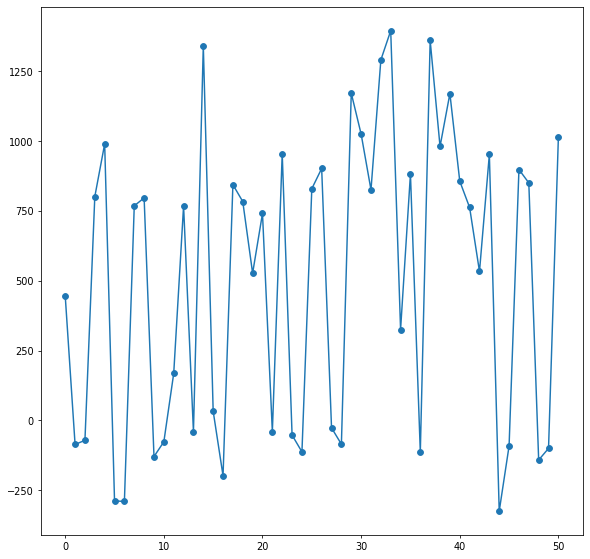

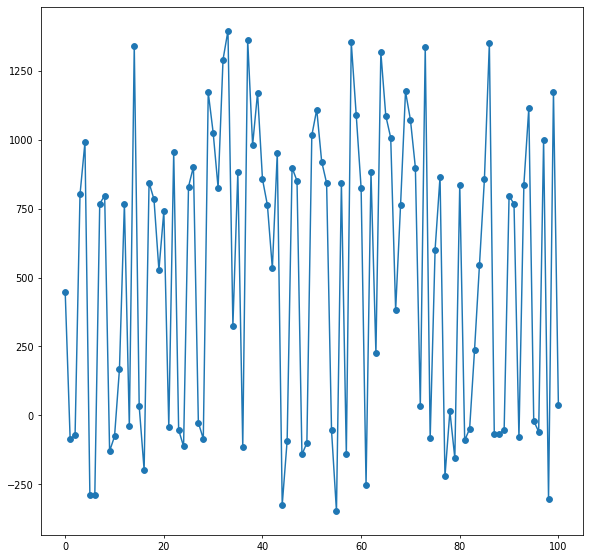

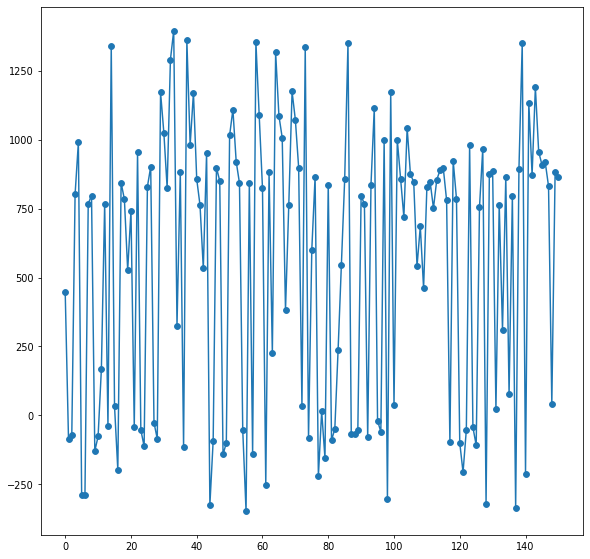

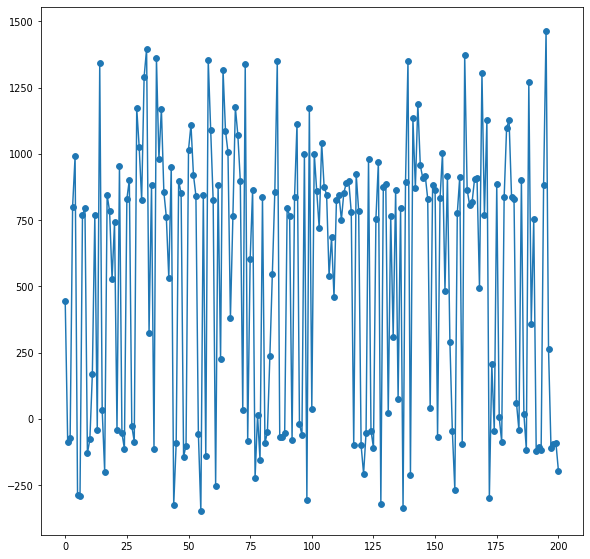

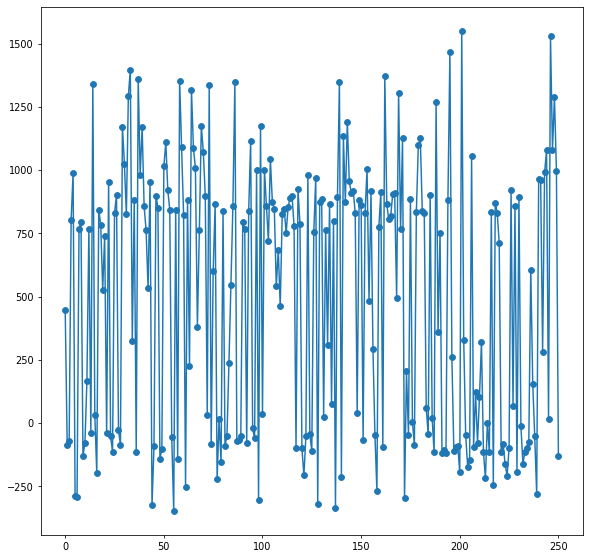

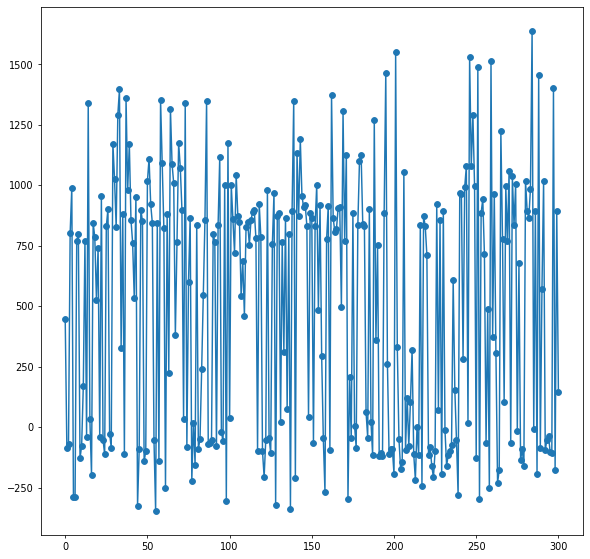

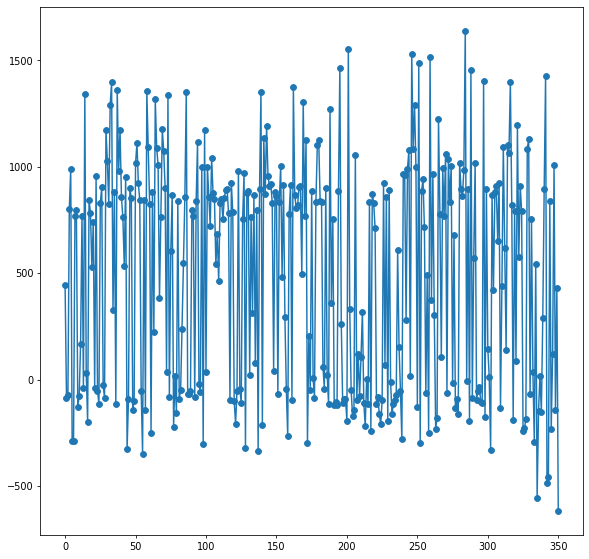

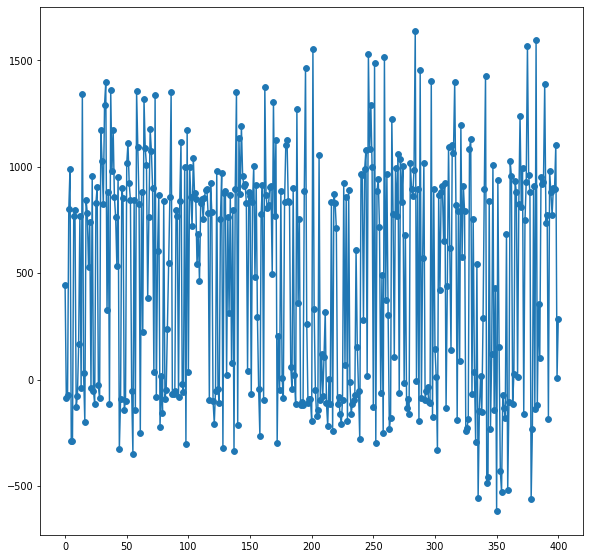

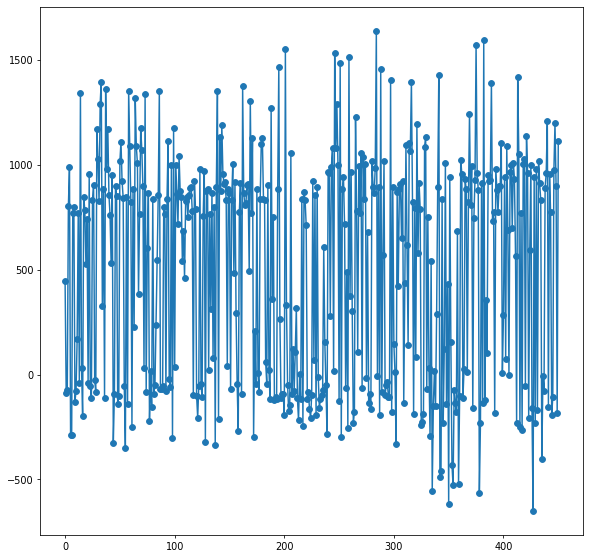

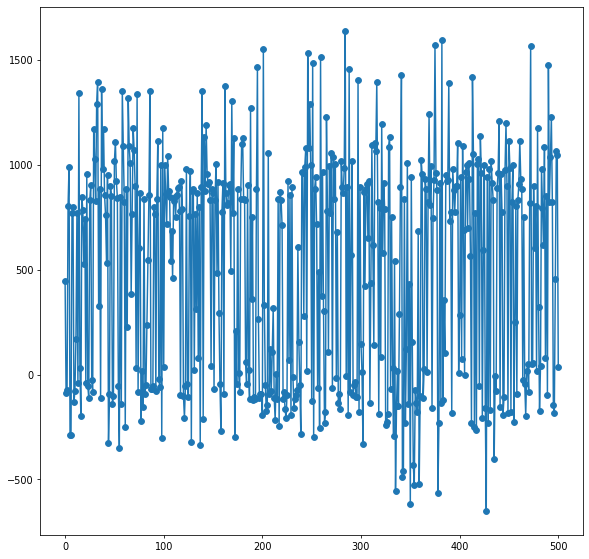

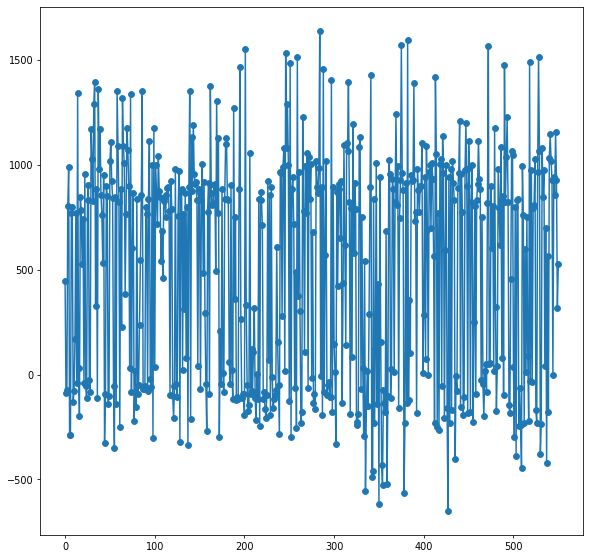

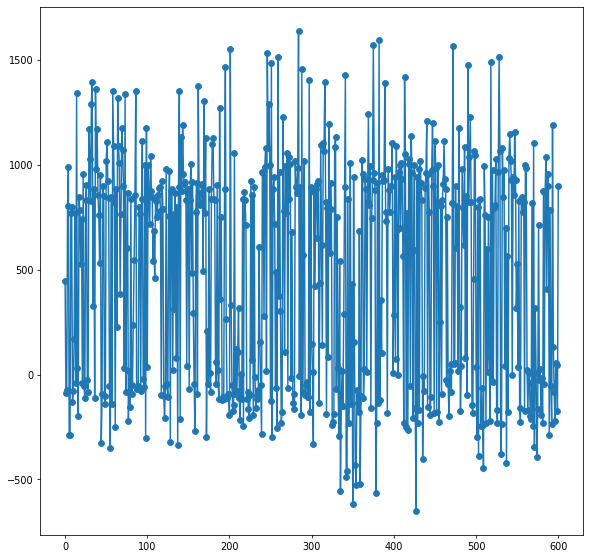

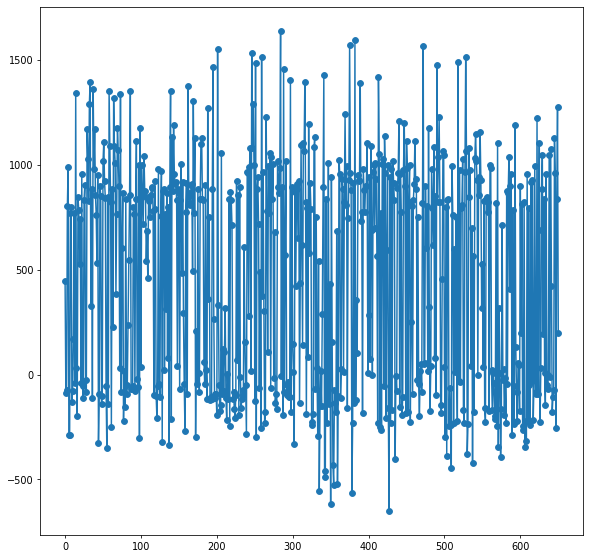

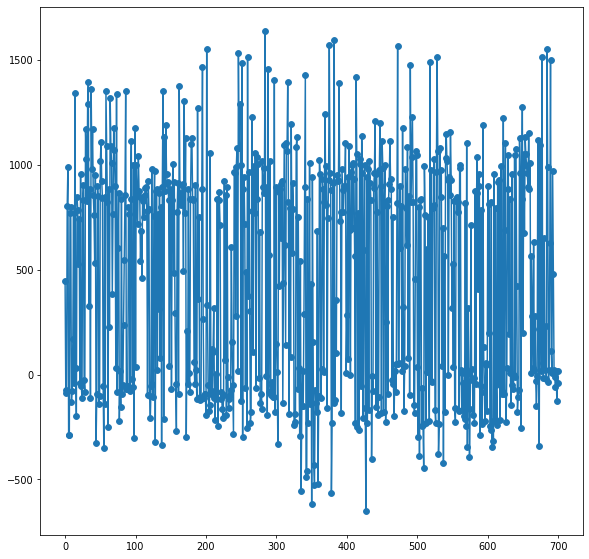

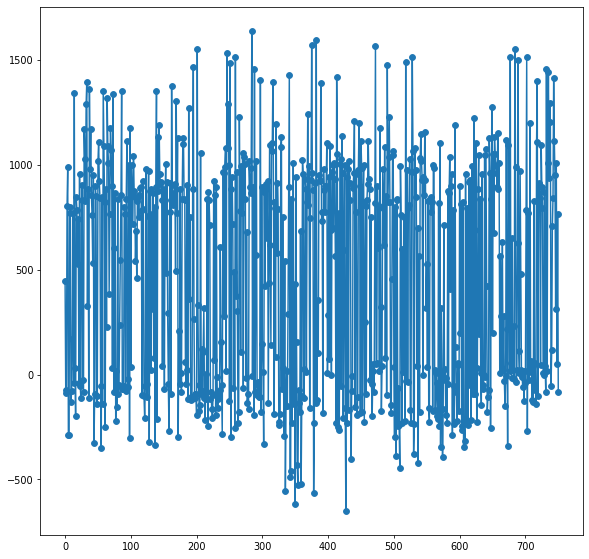

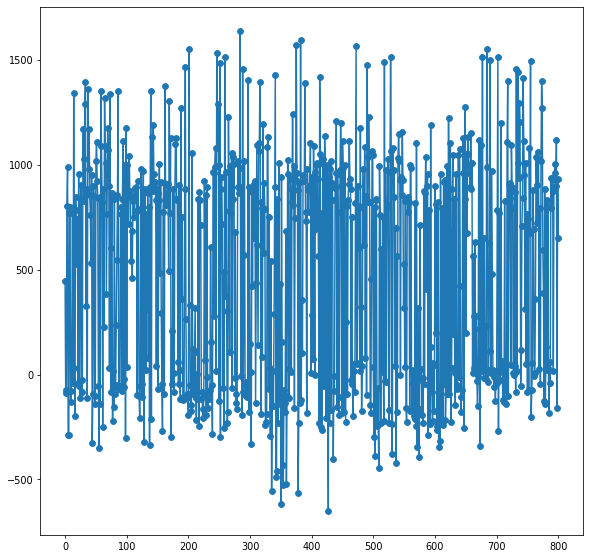

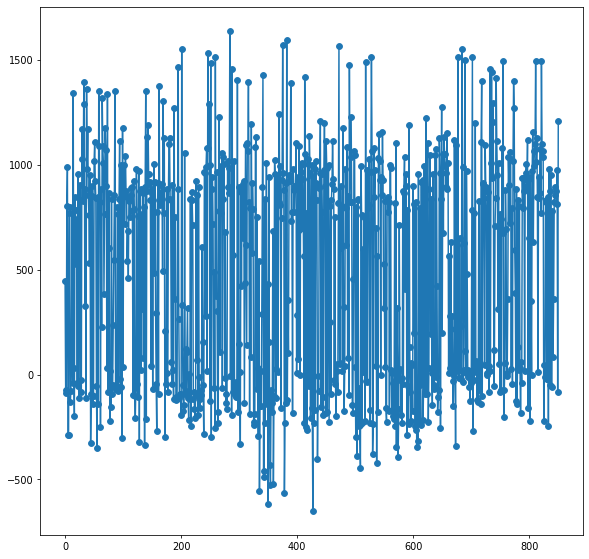

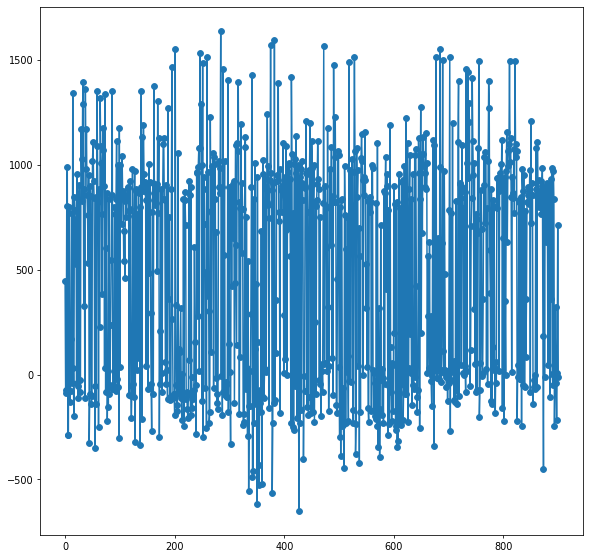

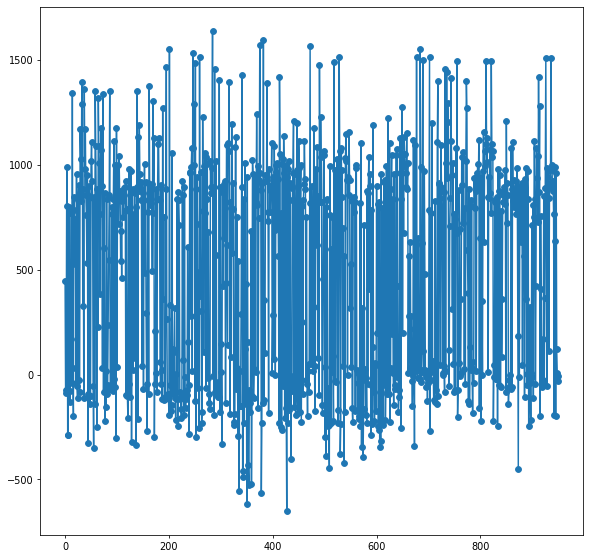

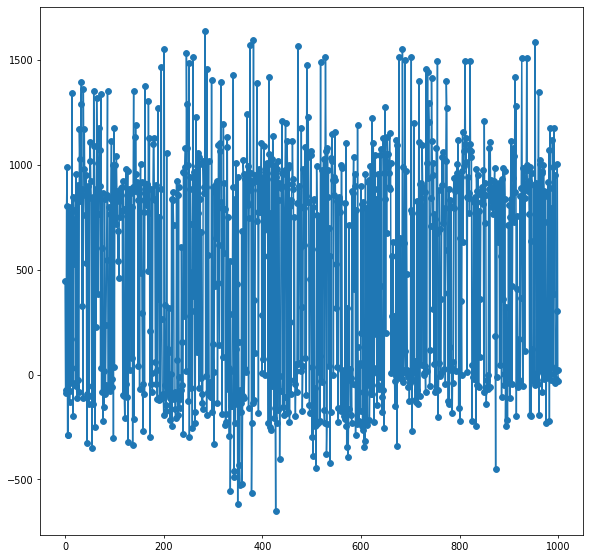

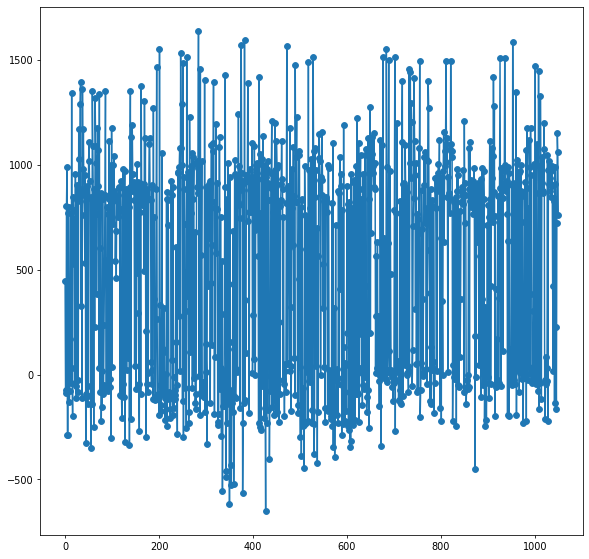

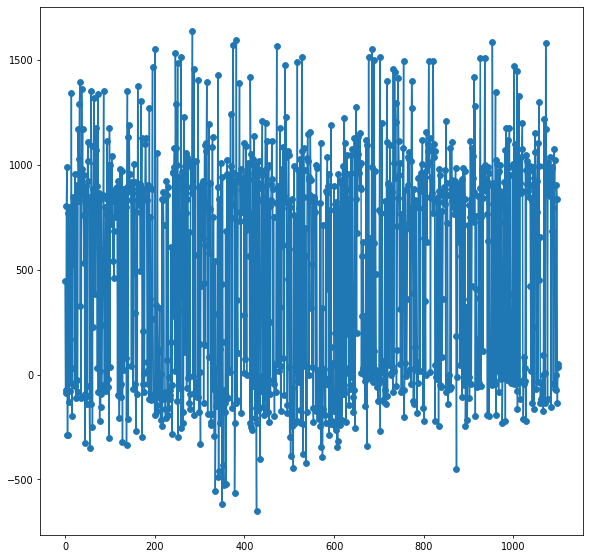

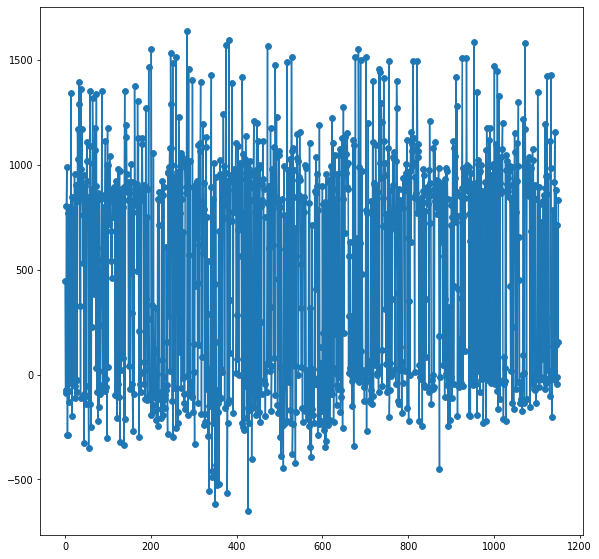

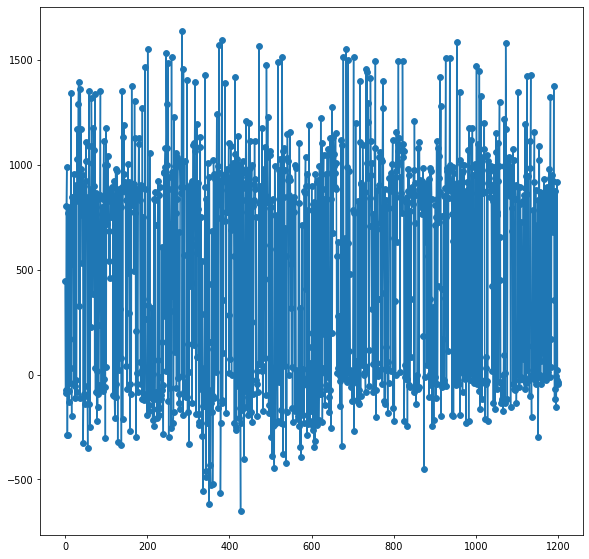

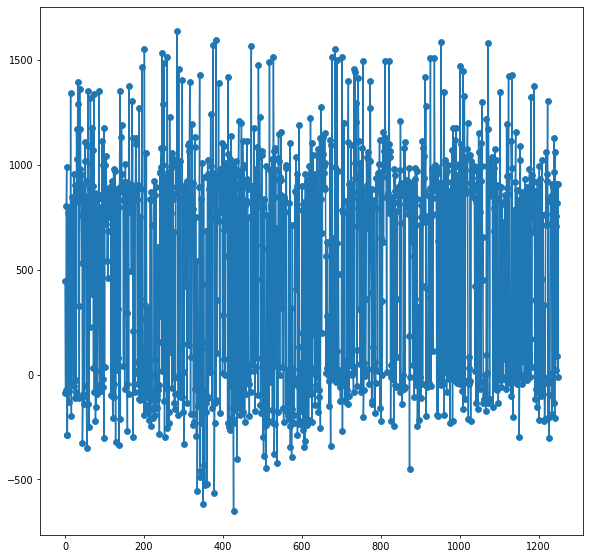

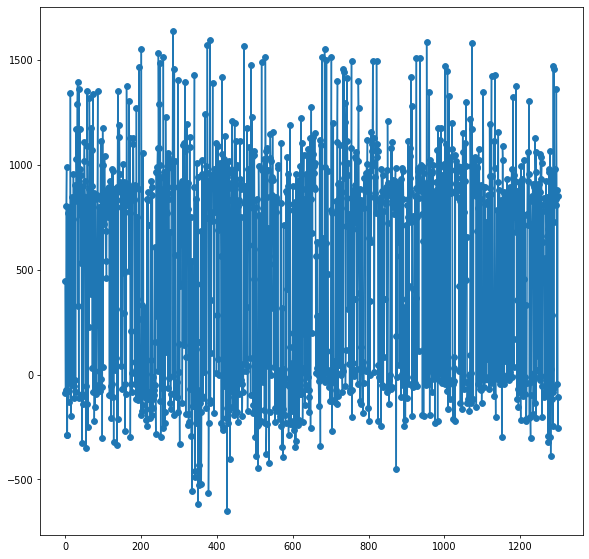

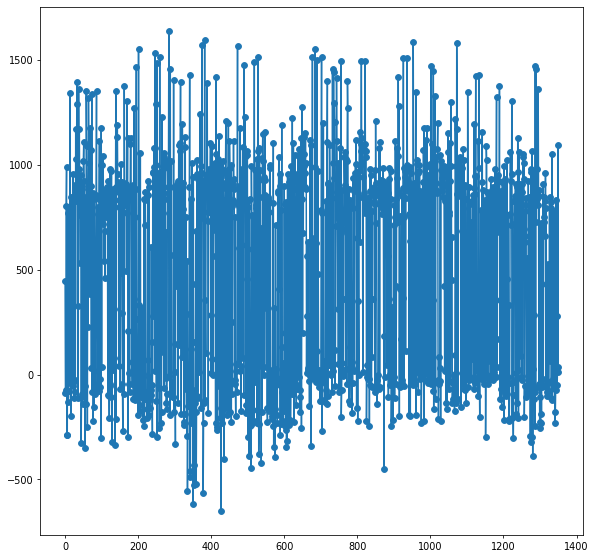

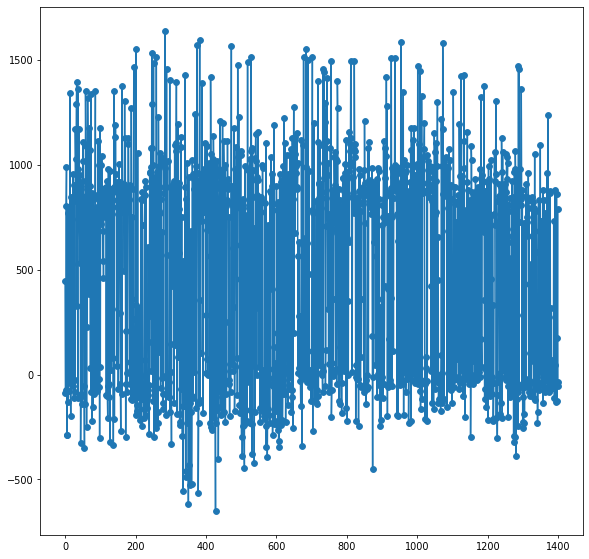

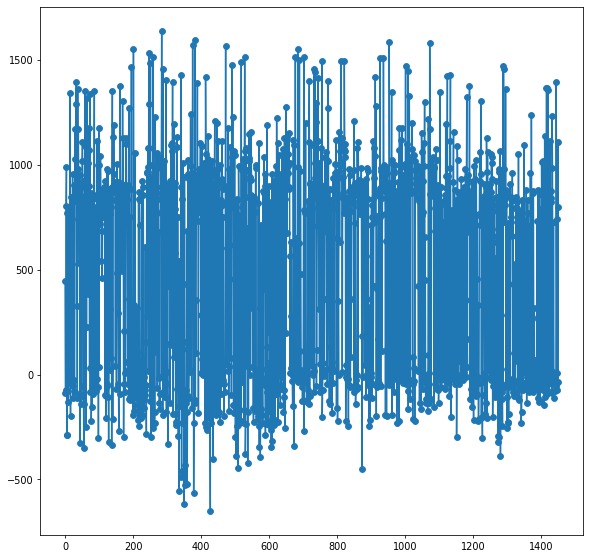

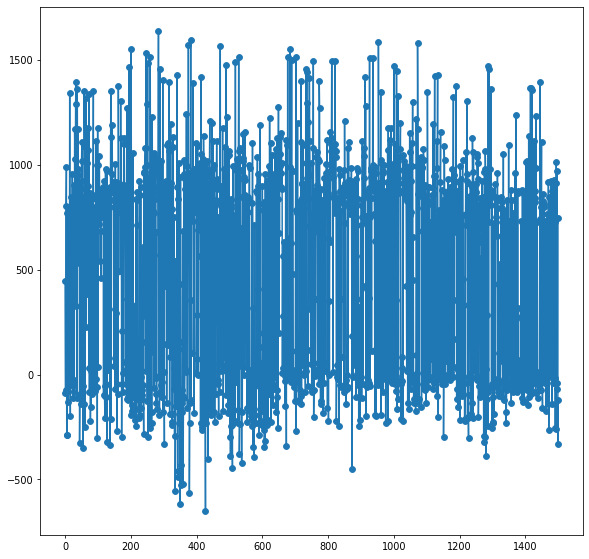

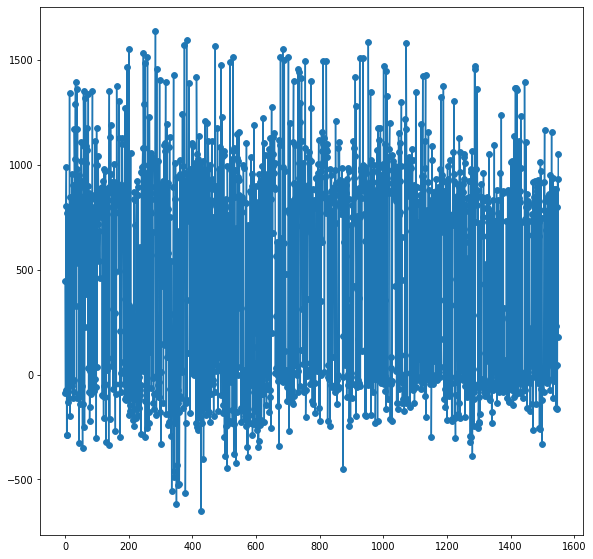

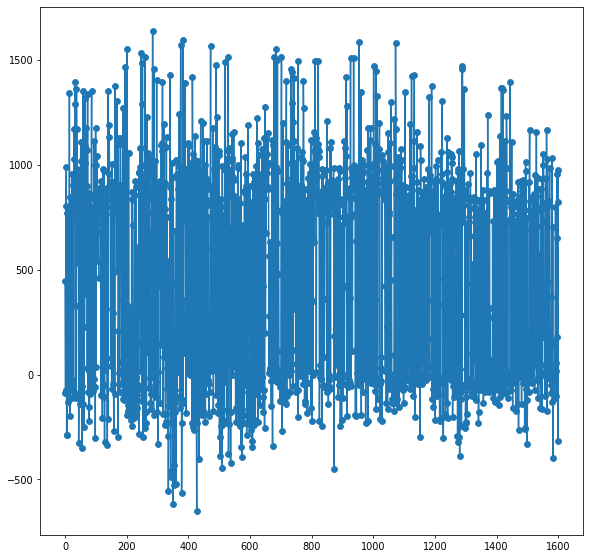

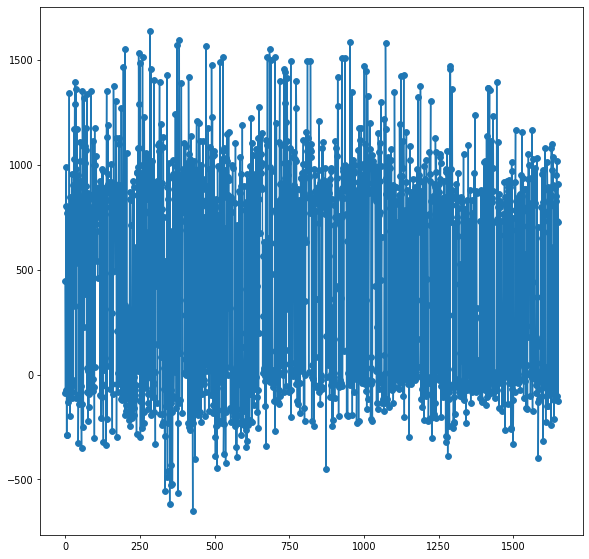

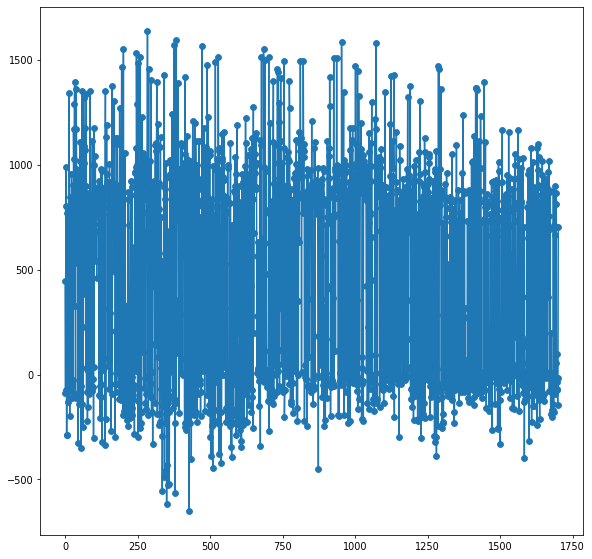

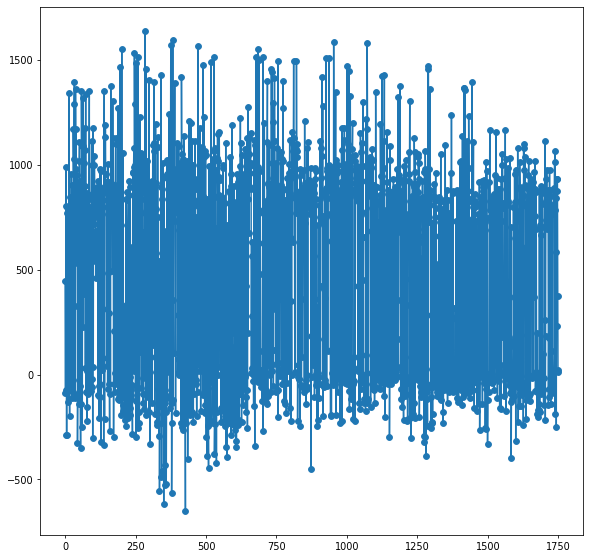

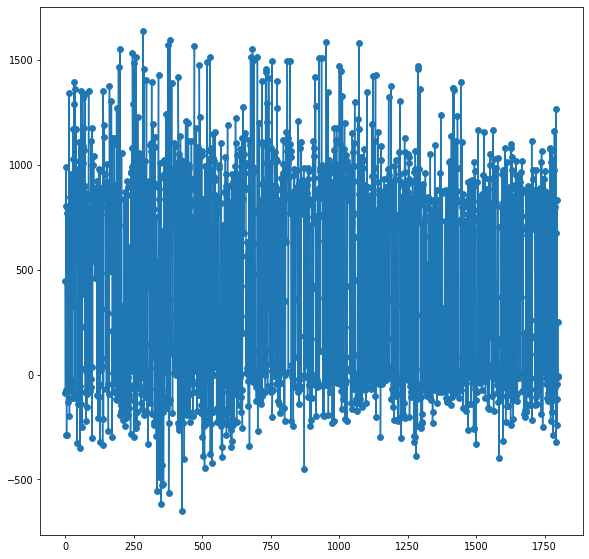

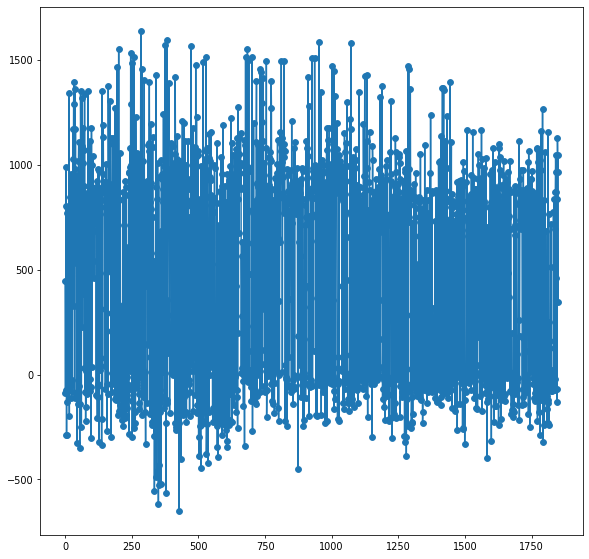

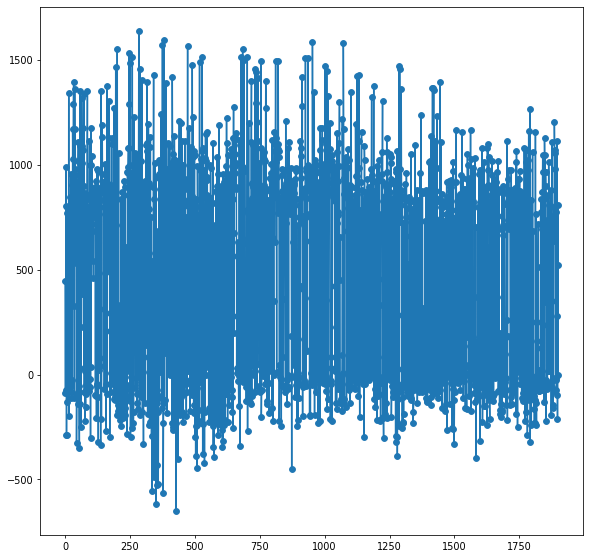

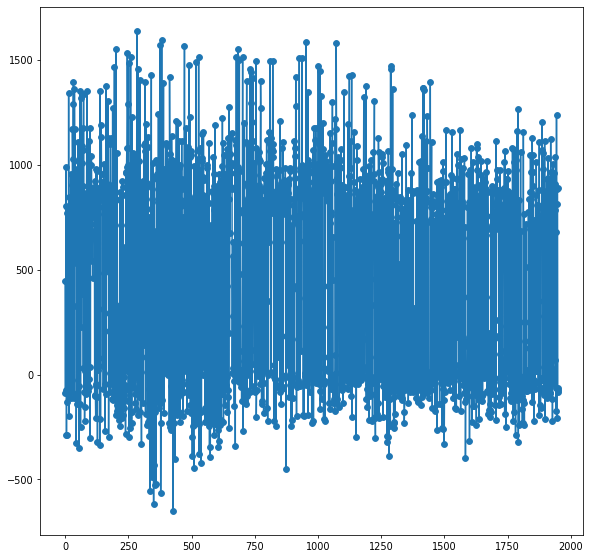

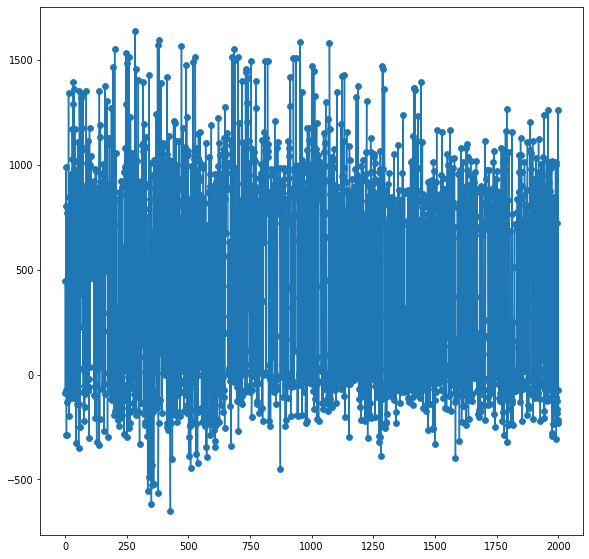

In [24]:
##############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                                             # 动作取值区间,对称区间，故只取上界
hidden_dim = 512
ddpg = DDPG(a_dim, s_dim, a_bound, hidden_dim)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 0.1

if LOAD_PRETRAIN:
    var = 0.2

list = [1, 2, 7, 8, 9, 11, 14, 16, 18, 25, 33]
    
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    l = random.choice(list)
    s = env.reset(level = l)
#     s = env.reset(level = 1)
    ep_reward = 0

    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            ddpg.Record_success(i)
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        r += info.get('qpos') * 4000
        #print(r)
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward/j)
            
            #if ddpg.pointer > ddpg.memory_capacity and done:
                #RENDER = True
            if (i % CHECK_POINT_EPI) == 0 and i != 0:
                ddpg.save('random10_75step_pre/' + str(i) + 'epi')
            
            break
               
print('Running time: ', time.time() - t1)